In [1]:
wpg_pattern_path = r'asset\datasets_flight-and-walking-imitation-data\wing_pattern_fmech.npy'
# Flight and walking reference data.
ref_flight_path = r'asset\datasets_flight-and-walking-imitation-data\flight-dataset_saccade-evasion_augmented.hdf5'
ref_walking_path = r'asset\datasets_flight-and-walking-imitation-data\walking-dataset_female-only_snippets-16252_trk-files-0-9.hdf5'

flight_policy_path = r'asset\trained-fly-policies\flight'
walk_policy_path = r'asset\trained-fly-policies\walking'
vision_bumps_path = r'asset\trained-fly-policies\vision-bumps'
vision_trench_path = r'asset\trained-fly-policies\vision-trench'

In [2]:
import numpy as np
import PIL.ImageDraw

import tensorflow as tf
import tensorflow_probability as tfp
from acme import wrappers

from flybody.fly_envs import (
    flight_imitation,
    walk_imitation,
    vision_guided_flight,
)
from flybody.tasks.task_utils import (
    get_random_policy,
    real2canonical,
)
from flybody.agents.utils_tf import TestPolicyWrapper
from flybody.utils import (
    display_video,
    rollout_and_render,
)

In [3]:
def blow(x, repeats=2):
    """Repeat columns and rows requested number of times."""
    return np.repeat(np.repeat(x, repeats, axis=0), repeats, axis=1)


def vision_rollout_and_render(env, policy, camera_id=1,
                              eye_blow_factor=5, **render_kwargs):
    """Run vision-guided flight episode and render frames, including eyes."""
    frames = []
    timestep = env.reset()
    # Run full episode until it ends.
    while timestep.step_type != 2:
        # Render eyes and scene.
        pixels = env.physics.render(camera_id=camera_id, **render_kwargs)
        eyes = eye_pixels_from_observation(
            timestep, blow_factor=eye_blow_factor)
        # Add eye pixels to scene.
        pixels[0:eyes.shape[0], 0:eyes.shape[1], :] = eyes
        frames.append(pixels)
        # Step environment.
        action = policy(timestep.observation)
        timestep = env.step(action)
    return frames


def eye_pixels_from_observation(timestep, blow_factor=4):
    """Get current eye view from timestep.observation."""
    # In the actual task, the averaging over axis=-1 is done by the visual
    # network as a pre-processing step, so effectively the visual observations
    # are gray-scale.
    left_eye = timestep.observation['walker/left_eye'].mean(axis=-1)
    right_eye = timestep.observation['walker/right_eye'].mean(axis=-1)
    pixels = np.concatenate((left_eye, right_eye), axis=1)
    pixels = np.tile(pixels[:, :, None], reps=(1, 1, 3))
    pixels = blow(pixels, blow_factor)
    half_size = pixels.shape[1] // 2
    # Add white line to separate eyes.
    pixels = np.concatenate((pixels[:, :half_size, :], 
                            255*np.ones((blow_factor*32, 2, 3)),
                            pixels[:, half_size:, :]), axis=1)
    pixels = pixels.astype('uint8')
    return pixels


def eye_pixels_from_cameras(physics, **render_kwargs):
    """Render two-eye view, assuming eye cameras have particular names."""
    for i in range(physics.model.ncam):
        name = physics.model.id2name(i, 'camera')
        if 'eye_left' in name:
            left_eye = physics.render(camera_id=i, **render_kwargs)
        if 'eye_right' in name:
            right_eye = physics.render(camera_id=i, **render_kwargs)
    pixels = np.hstack((left_eye, right_eye))
    return pixels


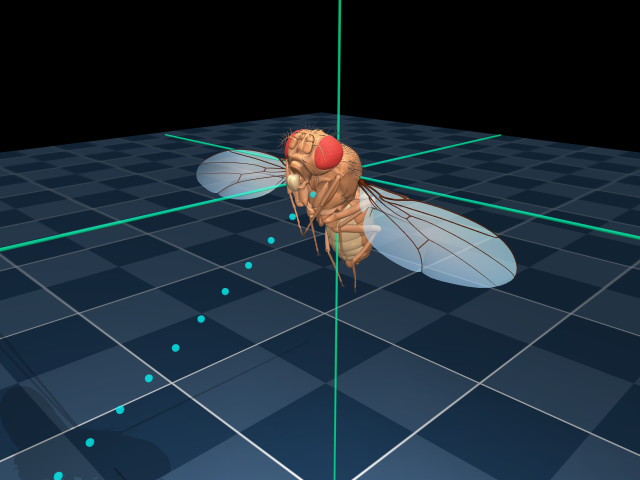

In [4]:
render_kwargs = {'width': 640, 'height': 480}
    
env = flight_imitation(wpg_pattern_path,
                    ref_flight_path,
                    terminal_com_dist=float('inf'))
# env = wrappers.SinglePrecisionWrapper(env)
# env = wrappers.CanonicalSpecWrapper(env, clip=True)

_ = env.reset()
pixels = env.physics.render(camera_id=1, **render_kwargs)
# 展示图片
PIL.Image.fromarray(pixels)

In [8]:
flight_policy = tf.saved_model.load(flight_policy_path)
# Wrap policy to work with non-batched observations at test time.
flight_policy = TestPolicyWrapper(flight_policy)


frames = rollout_and_render(env, flight_policy, run_until_termination=True,
                            camera_ids=1, **render_kwargs)
display_video(frames)

In [6]:
random_policy = get_random_policy(env.action_spec())

frames = rollout_and_render(env, random_policy, run_until_termination=True,
                            camera_ids=1, **render_kwargs)
display_video(frames)